In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [9]:
train=pd.read_csv('https://raw.githubusercontent.com/benvictoria21/pandas/master/dataset/HR%20Analytics-%20Job%20Change%20of%20Data%20Scientists/aug_train.csv')
test=pd.read_csv('https://raw.githubusercontent.com/benvictoria21/pandas/master/dataset/HR%20Analytics-%20Job%20Change%20of%20Data%20Scientists/aug_test.csv')
sample_submission=pd.read_csv('https://raw.githubusercontent.com/benvictoria21/pandas/master/dataset/HR%20Analytics-%20Job%20Change%20of%20Data%20Scientists/sample_submission.csv')

In [10]:
train.shape,test.shape

((19158, 14), (2129, 13))

In [11]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [12]:
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [13]:
train['target'].value_counts(normalize=True)

0.0    0.750652
1.0    0.249348
Name: target, dtype: float64

In [14]:
train.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [15]:
obj_cols=train.select_dtypes('object').columns
numeric_cols=[c for c in train.columns if c not in obj_cols if c not in ('target')]

In [16]:
for c in obj_cols:
    if list(set(test[c])-set(train[c])):
        print(f"For column {c} Available only in test are {list(set(test['city'])-set(train['city']))}")
    print("No instances found")

No instances found
No instances found
No instances found
No instances found
No instances found
No instances found
No instances found
No instances found
No instances found
No instances found


In [17]:
test.loc[:,'target']=-1
data=pd.concat([train,test],ignore_index=True)

In [18]:
stat_cols=[]
for c in obj_cols:
    stat_cols.append((c,data[c].nunique(),data[c].isnull().sum()*100/data[c].shape[0],data[c].value_counts(normalize=True,dropna=False).values[0]*100))
    stat_df=pd.DataFrame(stat_cols,columns=['column_name','unique_values','null_value_perc','perc_of_max_value'])
    stat_df.sort_values('unique_values',ascending=False,inplace=True)
stat_df

,column_name,unique_values,null_value_perc,perc_of_max_value
0,city,123,0.000000,22.680509
6,experience,22,0.328839,17.235872
7,company_size,8,30.816931,30.816931
5,major_discipline,6,14.680321,75.694086
8,company_type,6,31.822239,51.477428
9,last_new_job,6,2.175036,41.922300
4,education_level,5,2.405224,60.445342
1,gender,3,23.563677,68.966975
3,enrolled_university,3,1.958942,72.043970
2,relevent_experience,2,0.000000,71.950016


In [19]:
data['company_type'].value_counts(normalize=True,dropna=False)

Pvt Ltd                0.514774
NaN                    0.318222
Funded Startup         0.051581
Public Sector          0.050829
Early Stage Startup    0.031381
NGO                    0.026965
Other                  0.006248
Name: company_type, dtype: float64

In [20]:
null_cols=[c for c in obj_cols if c not in ['city','relevent_experience']]
for n in null_cols:
    print(f'Imputing null values in column {n}')
    data.loc[:,n]=data[n].fillna('NONE').astype('str')

Imputing null values in column gender
Imputing null values in column enrolled_university
Imputing null values in column education_level
Imputing null values in column major_discipline
Imputing null values in column experience
Imputing null values in column company_size
Imputing null values in column company_type
Imputing null values in column last_new_job


In [21]:
data['company_type'].value_counts(normalize=True,dropna=False)

Pvt Ltd                0.514774
NONE                   0.318222
Funded Startup         0.051581
Public Sector          0.050829
Early Stage Startup    0.031381
NGO                    0.026965
Other                  0.006248
Name: company_type, dtype: float64

In [22]:
stat_cols=[]
for c in obj_cols:
    stat_cols.append((c,data[c].nunique(),data[c].isnull().sum()*100/data[c].shape[0],data[c].value_counts(normalize=True,dropna=False).values[0]*100))
    stat_df=pd.DataFrame(stat_cols,columns=['column_name','unique_values','null_value_perc','perc_of_max_value'])
    stat_df.sort_values('unique_values',ascending=False,inplace=True)
stat_df

,column_name,unique_values,null_value_perc,perc_of_max_value
0,city,123,0.0,22.680509
6,experience,23,0.0,17.235872
7,company_size,9,0.0,30.816931
5,major_discipline,7,0.0,75.694086
8,company_type,7,0.0,51.477428
9,last_new_job,7,0.0,41.922300
4,education_level,6,0.0,60.445342
1,gender,4,0.0,68.966975
3,enrolled_university,4,0.0,72.043970
2,relevent_experience,2,0.0,71.950016


In [23]:
for c in ['relevent_experience','enrolled_university','gender']:
    temp=pd.get_dummies(data[c],prefix='OHE')
    data=pd.concat([data,temp],axis=1)
    print(f'OHE {c}.Now removing original column {c} from df')
    data.drop(c,axis=1,inplace=True)

OHE relevent_experience.Now removing original column relevent_experience from df
OHE enrolled_university.Now removing original column enrolled_university from df
OHE gender.Now removing original column gender from df


In [24]:
data[numeric_cols].isnull().sum()

enrollee_id               0
city_development_index    0
training_hours            0
dtype: int64

In [25]:
data.loc[:,'enrollee_id']=data.loc[:,'enrollee_id'].astype('object')

In [26]:
train=data.loc[data['target']!=-1,:].reset_index(drop=True)
test=data.loc[data['target']==-1,:].reset_index(drop=True)

In [27]:
X=train.drop('target',axis=1)
y=train.target.values

Text(0, 0.5, 'frequency')

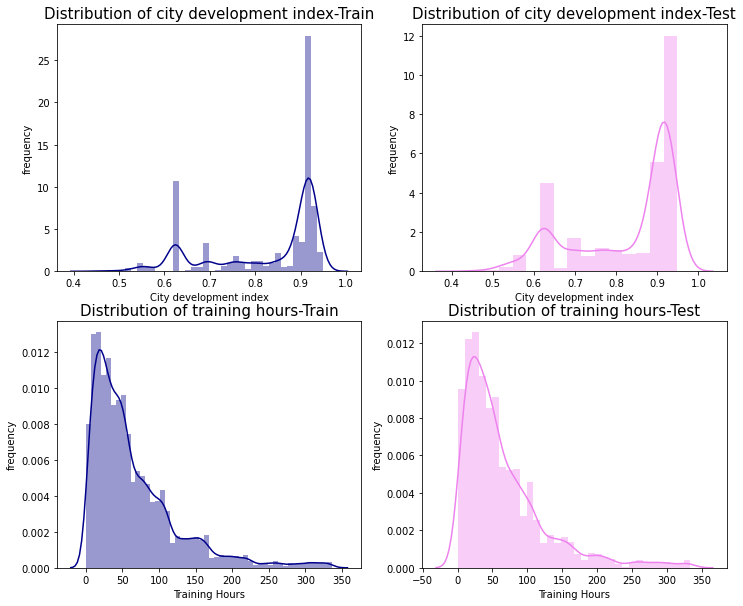

In [28]:
fig,ax=plt.subplots(figsize=(12,10))
plt.subplot(2,2,1)
sns.distplot(train['city_development_index'],color='darkblue')
plt.title("Distribution of city development index-Train",fontsize=15)
plt.xlabel('City development index',fontsize=10)
plt.ylabel('frequency')
plt.subplot(2,2,2)
sns.distplot(test['city_development_index'],color='violet')
plt.title("Distribution of city development index-Test",fontsize=15)
plt.xlabel('City development index',fontsize=10)
plt.ylabel('frequency')
plt.subplot(2,2,3)
sns.distplot(train['training_hours'],color='darkblue')
plt.title("Distribution of training hours-Train",fontsize=15)
plt.xlabel('Training Hours',fontsize=10)
plt.ylabel('frequency')
plt.subplot(2,2,4)
sns.distplot(test['training_hours'],color='violet')
plt.title("Distribution of training hours-Test",fontsize=15)
plt.xlabel('Training Hours',fontsize=10)
plt.ylabel('frequency')

In [30]:
train['training_hours'].describe(),test['training_hours'].describe()

(count    19158.000000
 mean        65.366896
 std         60.058462
 min          1.000000
 25%         23.000000
 50%         47.000000
 75%         88.000000
 max        336.000000
 Name: training_hours, dtype: float64,
 count    2129.000000
 mean       64.983091
 std        60.238660
 min         1.000000
 25%        23.000000
 50%        47.000000
 75%        86.000000
 max       334.000000
 Name: training_hours, dtype: float64)

In [31]:
freq_cols=['city','experience','company_size','major_discipline','company_type','last_new_job','education_level']

In [33]:
freq_cols=['city','experience','company_size','major_discipline','company_type','last_new_job','education_level']
required_cols=[c for c in X.columns if c not in ('enrollee_id')]
folds=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
def freq_encode(trn_df,val_df,cols):
    for c in cols:
        df=pd.concat([trn_df[[c]],val_df[[c]]])
        foo=df[c].value_counts().to_dict()
        trn_df[c]=trn_df[c].map(foo)
        val_df[c]=val_df[c].map(foo)
    return trn_df[cols],val_df[cols]
for i,(trn_idx,val_idx) in enumerate(folds.split(X,y)):
    print(f'***Starting fold {i+1}***')
    trn_x,trn_y=X[required_cols].iloc[trn_idx],y[trn_idx]
    val_x,val_y=X[required_cols].iloc[val_idx],y[val_idx]
    trn_x[freq_cols],val_x[freq_cols]=freq_encode(trn_x,val_x,freq_cols)
    #val_x[freq_cols]=freq_encode(val_x,freq_cols)
    clf=RandomForestClassifier(n_estimators=1000,oob_score=True,n_jobs=-1,random_state=40,max_features='sqrt')
    clf.fit(trn_x,trn_y)
    preds=clf.predict(val_x)
    score=f1_score(val_y,preds)
    print(f'F1 score for fold {i+1} is {score}')

***Starting fold 1***
F1 score for fold 1 is 0.49056603773584906
***Starting fold 2***
F1 score for fold 2 is 0.5220377790497996
***Starting fold 3***
F1 score for fold 3 is 0.5017421602787456
***Starting fold 4***
F1 score for fold 4 is 0.5357142857142857
***Starting fold 5***
F1 score for fold 5 is 0.5017709563164109
